In [1]:
pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from zipfile import ZipFile
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import random
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_optimizer import Lookahead
from torch.optim import AdamW
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
def graph(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="b")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color="r")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", color="g")
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", color="m")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [5]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_scheduler=False, save_path="best_model.pth"):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0
    best_epoch = 0
    best_results = {}

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    progress_bar = tqdm(total=num_epochs, desc="Training Progress", unit="epoch", dynamic_ncols=True, leave=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        if use_scheduler:
            scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_epoch = epoch + 1
            best_results = {
                "epoch": best_epoch,
                "train_loss": epoch_loss,
                "train_accuracy": epoch_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            }
            torch.save({
                "epoch": best_epoch,
                "state_dict": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_accuracy": best_val_acc
            }, save_path)
            best_model_msg = f"✅ Best model updated at epoch {best_epoch} with val acc {best_val_acc:.4f}"
        else:
            best_model_msg = ""

        progress_bar.set_postfix({
            "Train Loss": f"{epoch_loss:.4f}",
            "Train Acc": f"{epoch_accuracy:.4f}",
            "Val Loss": f"{val_loss:.4f}",
            "Val Acc": f"{val_accuracy:.4f}",
            "Best": best_model_msg
        })
        progress_bar.update(1)
        progress_bar.refresh()

    print("\nBest Model Found at Epoch {}: Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}".format(
        best_results["epoch"], best_results["train_loss"], best_results["train_accuracy"], best_results["val_loss"], best_results["val_accuracy"]
    ))

    global_best_path = "global_best_model.pth"

    if os.path.exists(global_best_path):
        prev_best = torch.load(global_best_path, map_location=device)
        prev_best_acc = prev_best.get("val_accuracy", 0)
    else:
        prev_best_acc = 0

    if best_results["val_accuracy"] > prev_best_acc:
        torch.save({
            "state_dict": model.state_dict(),
            "val_accuracy": best_results["val_accuracy"]
        }, global_best_path)
        print(f"🌍 New Global Best Model Saved with Val Acc: {best_results['val_accuracy']:.4f}")

    graph(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)

In [31]:
class TestDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.features = torch.tensor(self.data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.features[idx], idx

test_dataset = TestDataset(csv_path="/content/extracted/test.csv")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


def test_model(model, test_loader, device, model_path="global_best_model.pth", output_csv="predictions.csv"):

    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.to(device)
    model.eval()

    predictions = []
    indices = []

    with torch.no_grad():
        for features, idx in test_loader:
            features = features.to(device)

            features = features.view(features.size(0), 1, 28, 28)

            outputs = model(features)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            indices.extend(idx.numpy())

    df = pd.DataFrame({"id": indices, "label": predictions})
    df.to_csv(output_csv, index=False)

    print(f"✅ Predictions saved in {output_csv}")

In [6]:
zip_path = "/content/digit-recognizer.zip"

extract_path = "/content/extracted"
os.makedirs(extract_path, exist_ok=True)

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File extracted in:",extract_path)

File extracted in: /content/extracted


In [7]:
df = pd.read_csv("/content/extracted/train.csv")

labels = df["label"].values  # Array from 0 to 9
images = df.iloc[:, 1:].values  # all column except the first

# tensor of pytorch & normalization in [0;1]
X = torch.tensor(images, dtype=torch.float32) / 255.0
y = torch.tensor(labels, dtype=torch.long)

# Reshape in (batch_size, 1, 28, 28)
X = X.view(-1, 1, 28, 28)

# Training (80%) e validation (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Class of Transformations
class CustomTensorDataset(Dataset):
    def __init__(self, tensor, labels, transform=None):
        self.tensor = tensor
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):

        img = self.tensor[index]
        label = self.labels[index]

        if self.transform:
            img = transforms.ToPILImage()(img)
            img = self.transform(img)
        return img, label

    def __len__(self):
        return self.tensor.size(0)

# Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CustomTensorDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomTensorDataset(X_val, y_val, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set: {len(train_dataset)} image")
print(f"Validation set: {len(val_dataset)} image")

Training set: 33600 image
Validation set: 8400 image


In [8]:
# CNN
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # after the pooling, 28x28 became 7x7
        self.fc2 = nn.Linear(128, 10)           # 10 classes for 0-9

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = DigitCNN()

Training Progress: 100%|██████████| 10/10 [03:06<00:00, 17.88s/epoch, Train Loss=0.0581, Train Acc=0.9807, Val Loss=0.0336, Val Acc=0.9892, Best=✅ Best model updated at epoch 10 with val acc 0.9892]


Best Model Found at Epoch 10: Train Loss: 0.0581, Train Acc: 0.9807, Val Loss: 0.0336, Val Acc: 0.9892
🌍 New Global Best Model Saved with Val Acc: 0.9892


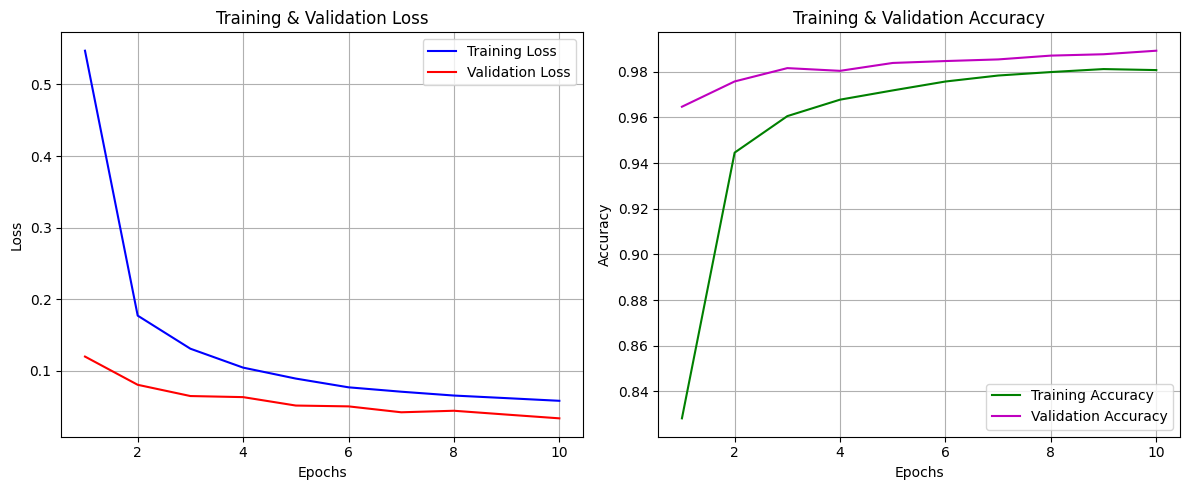

Training Progress: 100%|██████████| 10/10 [03:06<00:00, 18.69s/epoch, Train Loss=0.0581, Train Acc=0.9807, Val Loss=0.0336, Val Acc=0.9892, Best=✅ Best model updated at epoch 10 with val acc 0.9892]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Training Progress: 100%|██████████| 10/10 [02:55<00:00, 17.33s/epoch, Train Loss=0.0329, Train Acc=0.9896, Val Loss=0.0247, Val Acc=0.9914, Best=]


Best Model Found at Epoch 4: Train Loss: 0.0371, Train Acc: 0.9885, Val Loss: 0.0253, Val Acc: 0.9917
🌍 New Global Best Model Saved with Val Acc: 0.9917


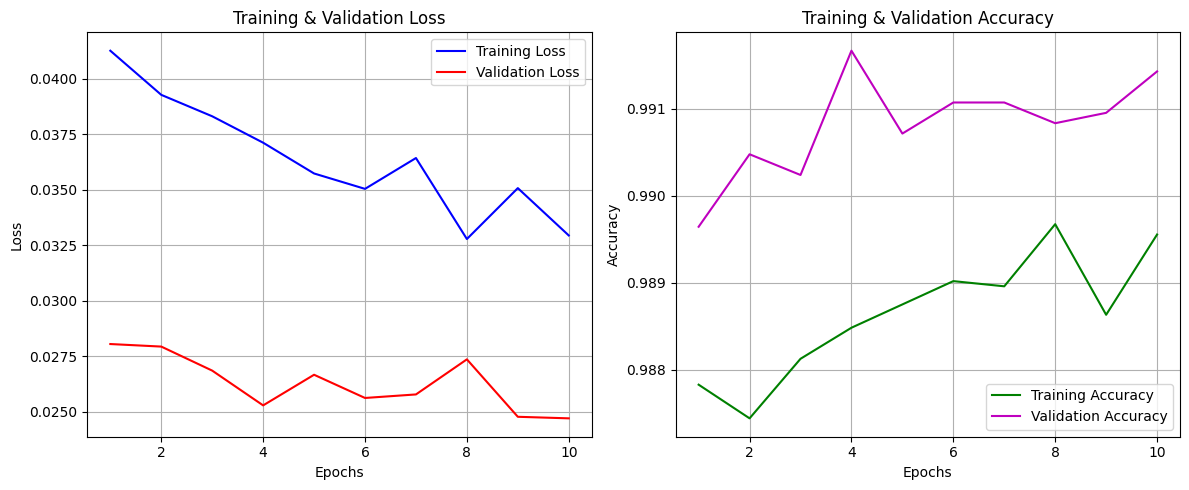

Training Progress: 100%|██████████| 10/10 [02:56<00:00, 17.61s/epoch, Train Loss=0.0329, Train Acc=0.9896, Val Loss=0.0247, Val Acc=0.9914, Best=]


In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Training Progress: 100%|██████████| 20/20 [05:46<00:00, 17.30s/epoch, Train Loss=0.0248, Train Acc=0.9919, Val Loss=0.0265, Val Acc=0.9910, Best=]


Best Model Found at Epoch 16: Train Loss: 0.0268, Train Acc: 0.9914, Val Loss: 0.0233, Val Acc: 0.9925
🌍 New Global Best Model Saved with Val Acc: 0.9925


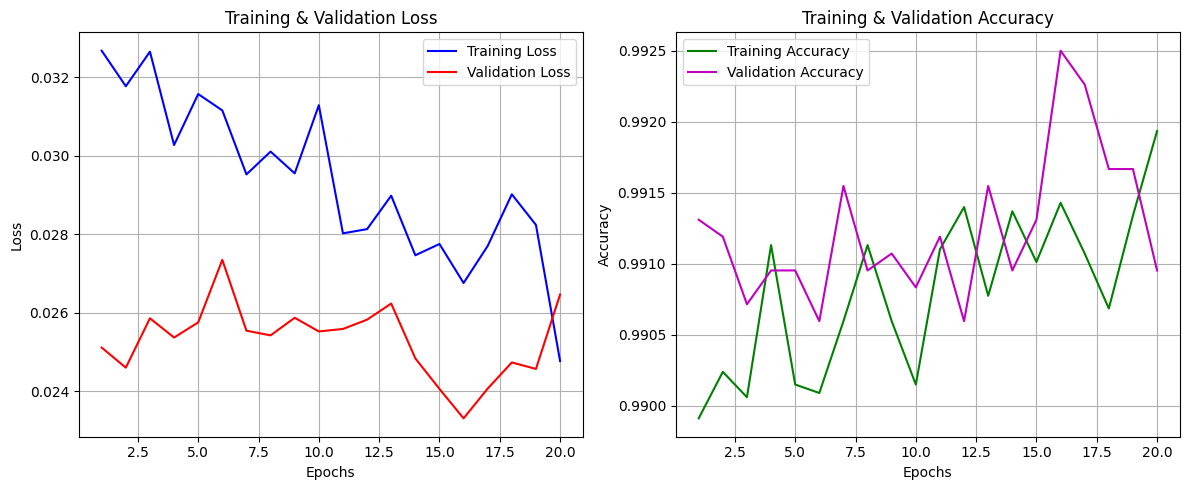

Training Progress: 100%|██████████| 20/20 [05:47<00:00, 17.36s/epoch, Train Loss=0.0248, Train Acc=0.9919, Val Loss=0.0265, Val Acc=0.9910, Best=]


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Training Progress: 100%|██████████| 20/20 [05:42<00:00, 17.07s/epoch, Train Loss=0.0227, Train Acc=0.9925, Val Loss=0.0247, Val Acc=0.9915, Best=]


Best Model Found at Epoch 16: Train Loss: 0.0233, Train Acc: 0.9928, Val Loss: 0.0230, Val Acc: 0.9925


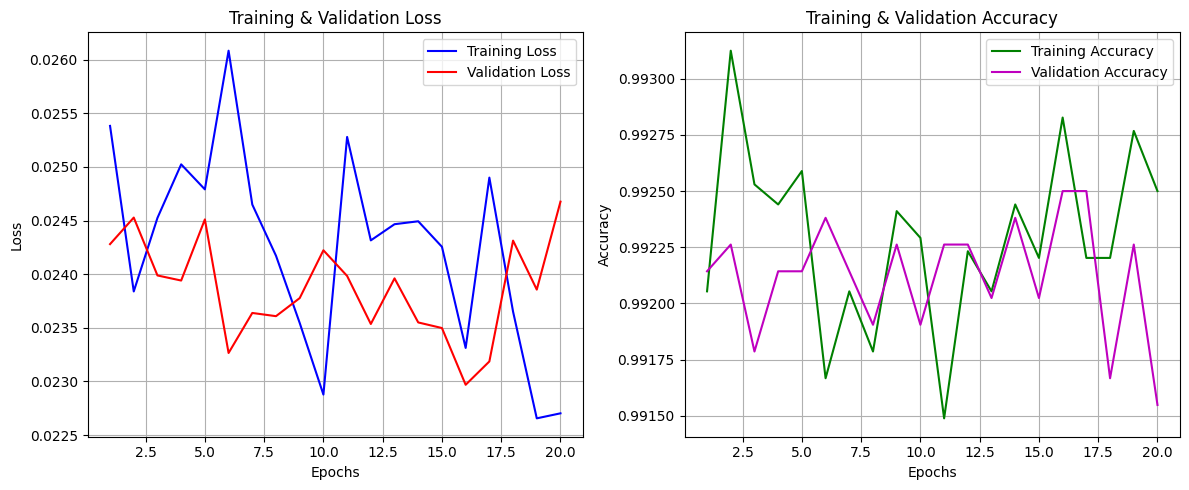

Training Progress: 100%|██████████| 20/20 [05:43<00:00, 17.15s/epoch, Train Loss=0.0227, Train Acc=0.9925, Val Loss=0.0247, Val Acc=0.9915, Best=]


In [12]:
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)



Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

Training Progress:   0%|          | 0/20 [00:18<?, ?epoch/s, Train Loss=0.0466, Train Acc=0.9850, Val Loss=0.0298, Val Acc=0.9910, Best=✅ Best model updated at epoch 1 with val acc 0.9910]

Training Progress:   5%|▌         | 1/20 [00:18<05:42, 18.04s/epoch, Train Loss=0.0466, Train Acc=0.9850, Val Loss=0.0298, Val Acc=0.9910, Best=✅ Best model updated at epoch 1 with val acc 0.9910]

Training Progress:   5%|▌         | 1/20 [00:18<05:42, 18.04s/epoch, Train Loss=0.0466, Train Acc=0.9850, Val Loss=0.0298, Val Acc=0.9910, Best=✅ Best model updated at epoch 1 with val acc 0.9910]

Training Progress:   5%|▌         | 1/20 [00:35<05:42, 18.04s/epoch, Train Loss=0.0430, Train Acc=0.9860, Val Loss=0.0336, Val Acc=0.9894, Best=]                                                    

Training Progress:  10%|█         | 2/20 [00:35<05:15, 17.52s/epoch, Train Loss=0.0430, Train Acc=0.9860, Val Loss=0.0336, Val Acc=0.9894, Best=]

Trai


Best Model Found at Epoch 18: Train Loss: 0.0168, Train Acc: 0.9947, Val Loss: 0.0194, Val Acc: 0.9936
🌍 New Global Best Model Saved with Val Acc: 0.9936


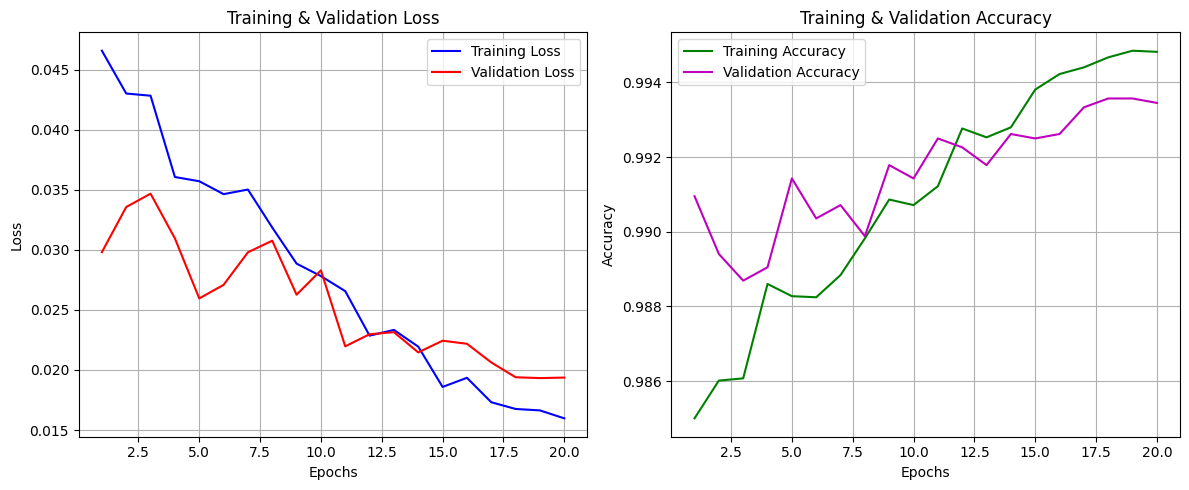

Training Progress: 100%|██████████| 20/20 [05:50<00:00, 17.54s/epoch, Train Loss=0.0160, Train Acc=0.9948, Val Loss=0.0194, Val Acc=0.9935, Best=]


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_scheduler = True)






Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]




Training Progress:   0%|          | 0/20 [00:17<?, ?epoch/s, Train Loss=0.5655, Train Acc=0.9907, Val Loss=0.5484, Val Acc=0.9925, Best=✅ Best model updated at epoch 1 with val acc 0.9925]




Training Progress:   5%|▌         | 1/20 [00:17<05:38, 17.80s/epoch, Train Loss=0.5655, Train Acc=0.9907, Val Loss=0.5484, Val Acc=0.9925, Best=✅ Best model updated at epoch 1 with val acc 0.9925]




Training Progress:   5%|▌         | 1/20 [00:17<05:38, 17.80s/epoch, Train Loss=0.5655, Train Acc=0.9907, Val Loss=0.5484, Val Acc=0.9925, Best=✅ Best model updated at epoch 1 with val acc 0.9925]




Training Progress:   5%|▌         | 1/20 [00:34<05:38, 17.80s/epoch, Train Loss=0.5598, Train Acc=0.9910, Val Loss=0.5456, Val Acc=0.9929, Best=✅ Best model updated at epoch 2 with val acc 0.9929]




Training Progress:  10%|█         | 2/20 [00:34<05:13, 17.42s/epoch, Train Loss=0.5598, Train Acc=0.9910, Val Loss=0.5456, Val Acc=0.9


Best Model Found at Epoch 12: Train Loss: 0.5435, Train Acc: 0.9933, Val Loss: 0.5338, Val Acc: 0.9944
🌍 New Global Best Model Saved with Val Acc: 0.9944


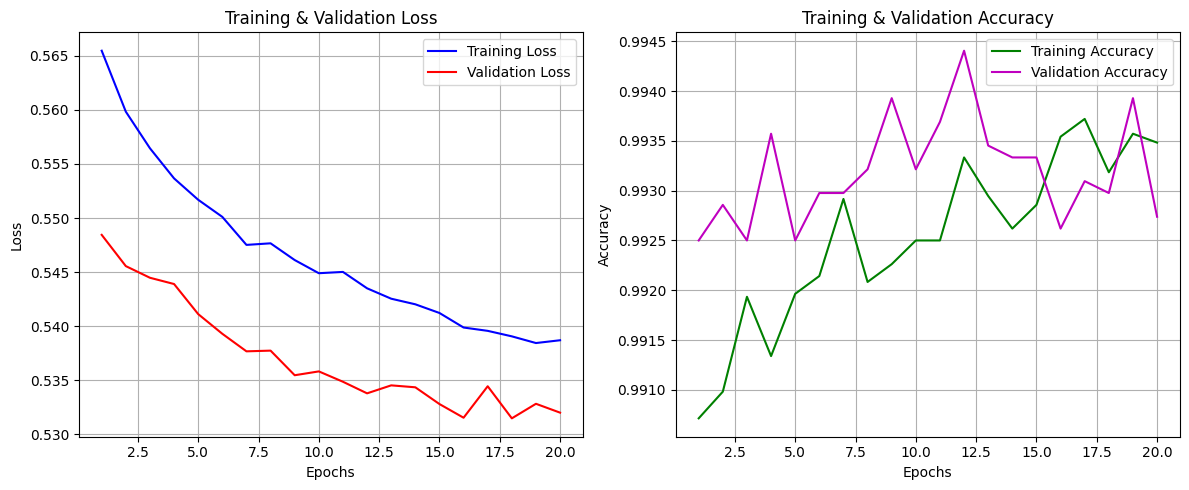

Training Progress: 100%|██████████| 20/20 [05:48<00:00, 17.41s/epoch, Train Loss=0.5387, Train Acc=0.9935, Val Loss=0.5320, Val Acc=0.9927, Best=]


In [22]:
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)




Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   0%|          | 0/20 [00:17<?, ?epoch/s, Train Loss=0.5375, Train Acc=0.9932, Val Loss=0.5304, Val Acc=0.9939, Best=✅ Best model updated at epoch 1 with val acc 0.9939]


Training Progress:   5%|▌         | 1/20 [00:17<05:25, 17.14s/epoch, Train Loss=0.5375, Train Acc=0.9932, Val Loss=0.5304, Val Acc=0.9939, Best=✅ Best model updated at epoch 1 with val acc 0.9939]


Training Progress:   5%|▌         | 1/20 [00:17<05:25, 17.14s/epoch, Train Loss=0.5375, Train Acc=0.9932, Val Loss=0.5304, Val Acc=0.9939, Best=✅ Best model updated at epoch 1 with val acc 0.9939]


Training Progress:   5%|▌         | 1/20 [00:35<05:25, 17.14s/epoch, Train Loss=0.5363, Train Acc=0.9941, Val Loss=0.5301, Val Acc=0.9935, Best=]                                                    


Training Progress:  10%|█         | 2/20 [00:35<05:17, 17.62s/epoch, Train Loss=0.5363, Train Acc=0.9941, Val Loss=0.5301, Val Acc=0.9935, Best=]


Best Model Found at Epoch 19: Train Loss: 0.5316, Train Acc: 0.9942, Val Loss: 0.5265, Val Acc: 0.9948
🌍 New Global Best Model Saved with Val Acc: 0.9948


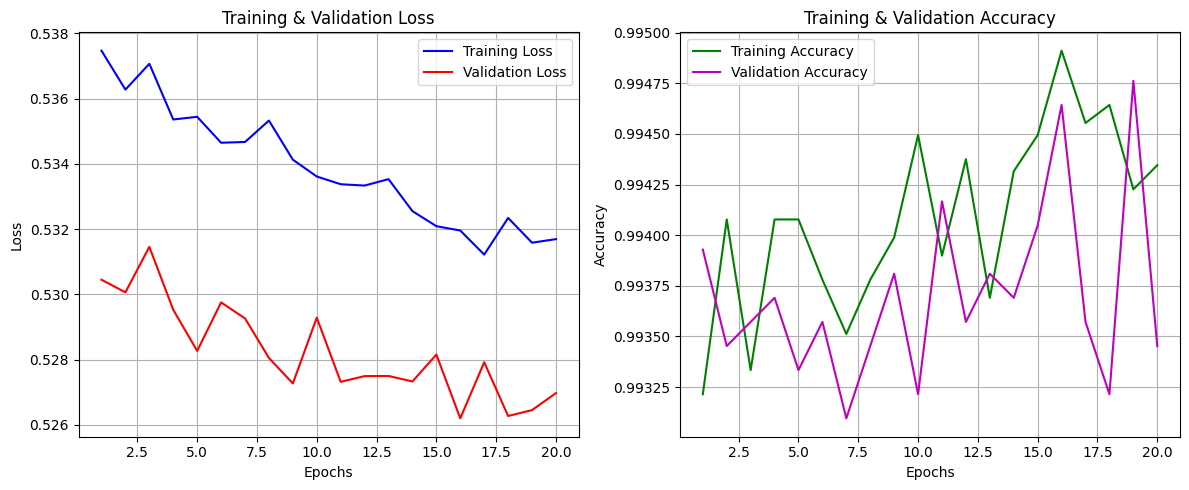

Training Progress: 100%|██████████| 20/20 [05:47<00:00, 17.39s/epoch, Train Loss=0.5317, Train Acc=0.9943, Val Loss=0.5270, Val Acc=0.9935, Best=]


In [23]:
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)




Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]


Training Progress:   0%|          | 0/20 [00:17<?, ?epoch/s, Train Loss=0.5304, Train Acc=0.9946, Val Loss=0.5275, Val Acc=0.9942, Best=✅ Best model updated at epoch 1 with val acc 0.9942]


Training Progress:   5%|▌         | 1/20 [00:17<05:26, 17.19s/epoch, Train Loss=0.5304, Train Acc=0.9946, Val Loss=0.5275, Val Acc=0.9942, Best=✅ Best model updated at epoch 1 with val acc 0.9942]


Training Progress:   5%|▌         | 1/20 [00:17<05:26, 17.19s/epoch, Train Loss=0.5304, Train Acc=0.9946, Val Loss=0.5275, Val Acc=0.9942, Best=✅ Best model updated at epoch 1 with val acc 0.9942]


Training Progress:   5%|▌         | 1/20 [00:34<05:26, 17.19s/epoch, Train Loss=0.5308, Train Acc=0.9947, Val Loss=0.5259, Val Acc=0.9931, Best=]                                                    


Training Progress:  10%|█         | 2/20 [00:34<05:07, 17.06s/epoch, Train Loss=0.5308, Train Acc=0.9947, Val Loss=0.5259, Val Acc=0.9931, Best=]


Best Model Found at Epoch 14: Train Loss: 0.5237, Train Acc: 0.9960, Val Loss: 0.5217, Val Acc: 0.9950
🌍 New Global Best Model Saved with Val Acc: 0.9950


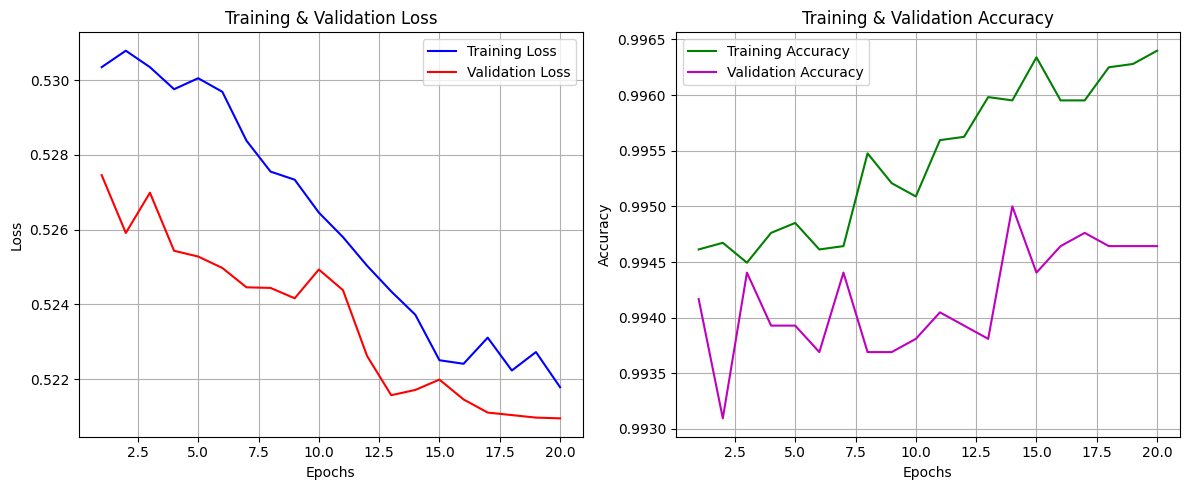

Training Progress: 100%|██████████| 20/20 [05:47<00:00, 17.37s/epoch, Train Loss=0.5218, Train Acc=0.9964, Val Loss=0.5209, Val Acc=0.9946, Best=]


In [24]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
batch_size = 64

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_scheduler = True)






Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]




Training Progress:   0%|          | 0/20 [00:17<?, ?epoch/s, Train Loss=0.0203, Train Acc=0.9940, Val Loss=0.0194, Val Acc=0.9936, Best=✅ Best model updated at epoch 1 with val acc 0.9936]




Training Progress:   5%|▌         | 1/20 [00:17<05:39, 17.87s/epoch, Train Loss=0.0203, Train Acc=0.9940, Val Loss=0.0194, Val Acc=0.9936, Best=✅ Best model updated at epoch 1 with val acc 0.9936]




Training Progress:   5%|▌         | 1/20 [00:17<05:39, 17.87s/epoch, Train Loss=0.0203, Train Acc=0.9940, Val Loss=0.0194, Val Acc=0.9936, Best=✅ Best model updated at epoch 1 with val acc 0.9936]




Training Progress:   5%|▌         | 1/20 [00:34<05:39, 17.87s/epoch, Train Loss=0.0173, Train Acc=0.9943, Val Loss=0.0169, Val Acc=0.9938, Best=✅ Best model updated at epoch 2 with val acc 0.9938]




Training Progress:  10%|█         | 2/20 [00:34<05:08, 17.15s/epoch, Train Loss=0.0173, Train Acc=0.9943, Val Loss=0.0169, Val Acc=0.9


Best Model Found at Epoch 12: Train Loss: 0.0113, Train Acc: 0.9966, Val Loss: 0.0170, Val Acc: 0.9950


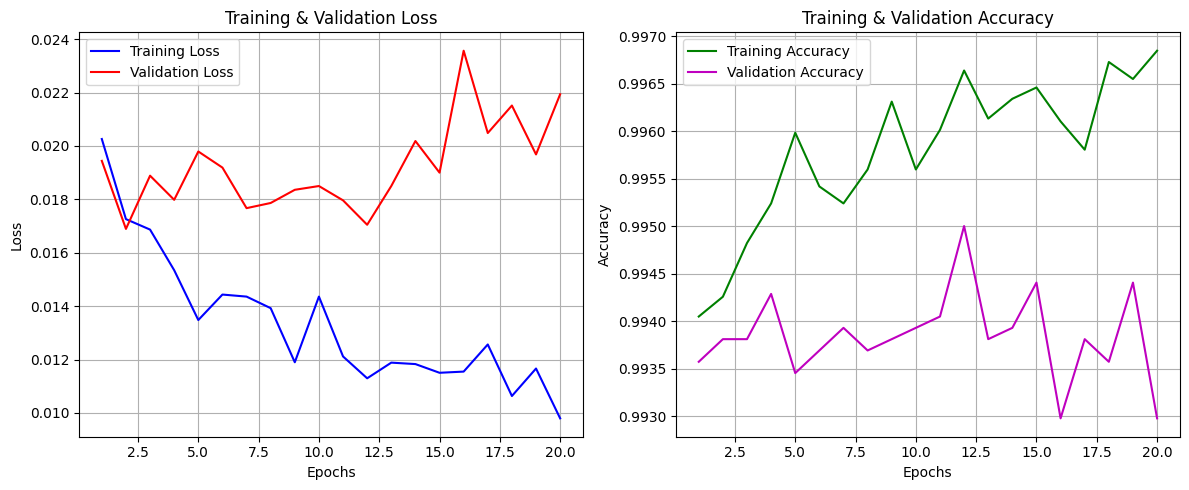

Training Progress: 100%|██████████| 20/20 [05:44<00:00, 17.23s/epoch, Train Loss=0.0098, Train Acc=0.9968, Val Loss=0.0219, Val Acc=0.9930, Best=]


In [26]:
optimizer = AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

criterion = nn.CrossEntropyLoss()
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)







Training Progress:   0%|          | 0/30 [00:00<?, ?epoch/s]




Training Progress:   0%|          | 0/30 [00:16<?, ?epoch/s, Train Loss=0.0146, Train Acc=0.9955, Val Loss=0.0229, Val Acc=0.9933, Best=✅ Best model updated at epoch 1 with val acc 0.9933]




Training Progress:   3%|▎         | 1/30 [00:16<08:01, 16.62s/epoch, Train Loss=0.0146, Train Acc=0.9955, Val Loss=0.0229, Val Acc=0.9933, Best=✅ Best model updated at epoch 1 with val acc 0.9933]




Training Progress:   3%|▎         | 1/30 [00:16<08:01, 16.62s/epoch, Train Loss=0.0146, Train Acc=0.9955, Val Loss=0.0229, Val Acc=0.9933, Best=✅ Best model updated at epoch 1 with val acc 0.9933]




Training Progress:   3%|▎         | 1/30 [00:33<08:01, 16.62s/epoch, Train Loss=0.0172, Train Acc=0.9947, Val Loss=0.0201, Val Acc=0.9938, Best=✅ Best model updated at epoch 2 with val acc 0.9938]




Training Progress:   7%|▋         | 2/30 [00:33<07:46, 16.66s/epoch, Train Loss=0.0172, Train Acc=0.9947, Val Loss=0.0201, Val Acc=0.9


Best Model Found at Epoch 5: Train Loss: 0.0171, Train Acc: 0.9943, Val Loss: 0.0217, Val Acc: 0.9943


Training Progress:   0%|          | 0/20 [33:13<?, ?epoch/s]


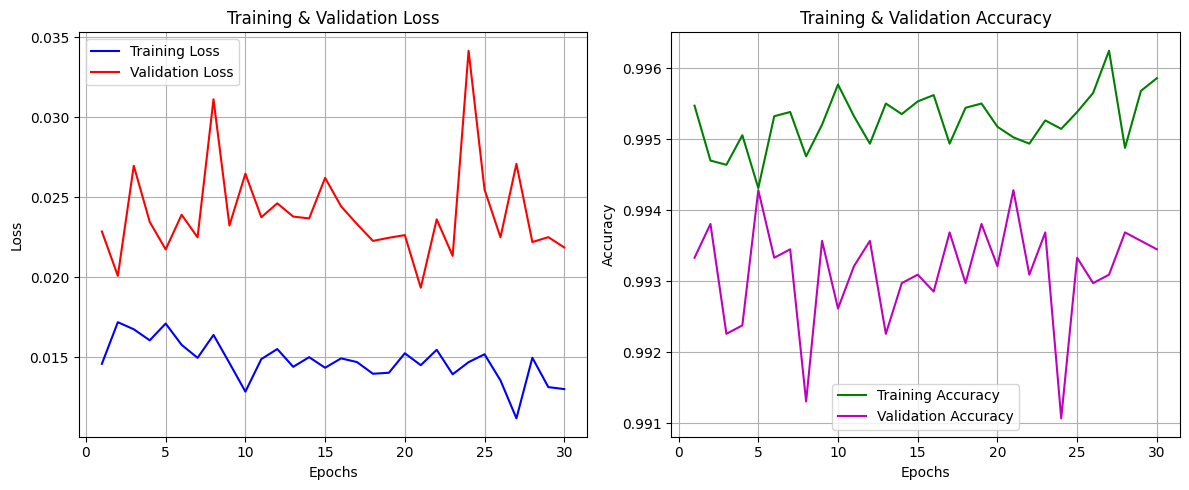

Training Progress: 100%|██████████| 30/30 [08:27<00:00, 16.90s/epoch, Train Loss=0.0130, Train Acc=0.9959, Val Loss=0.0219, Val Acc=0.9935, Best=]


In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

In [32]:
test_model(model, test_loader, device)

✅ Predictions saved in predictions.csv
